/var/folders/q9/rjz_bd012p38q8svx3x4q0pm0000gn/T/ipykernel_80040/2048681799.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("team", group_keys=False).apply(add_rolling_features)


Test accuracy (pre-match SVM): 0.431

Classification report:
              precision    recall  f1-score   support

           A      0.385     0.495     0.433       101
           D      0.526     0.159     0.244        63
           H      0.464     0.527     0.494       110

    accuracy                          0.431       274
   macro avg      0.458     0.394     0.390       274
weighted avg      0.449     0.431     0.414       274



<Figure size 600x500 with 0 Axes>

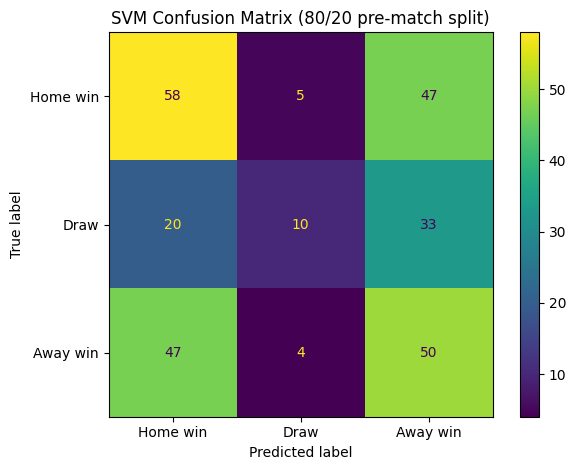

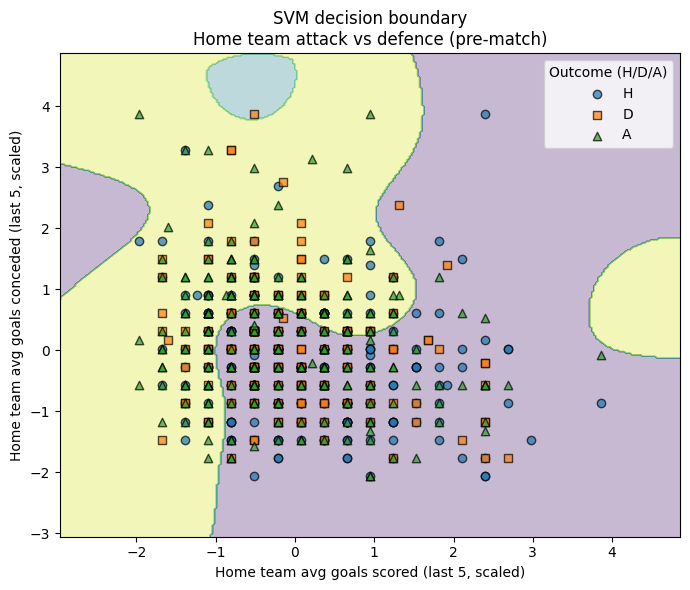


Computing permutation feature importance (this may take a bit)...

Top feature importances (pre-match features only):
cat__venue_Home: 0.0268
num__poss_roll_5: 0.0231
cat__venue_Away: 0.0158
num__xga_roll_5: 0.0146
num__fk_roll_5: 0.0134
num__points_roll_5: 0.0073
num__pkatt_roll_5: 0.0073
cat__day_Mon: 0.0049
num__xg_roll_5: 0.0049
num__ga_roll_5: 0.0024
cat__day_Fri: 0.0012
num__sot_roll_5: -0.0085
cat__day_Sat: -0.0122
num__pk_roll_5: -0.0146
num__dist_roll_5: -0.0158


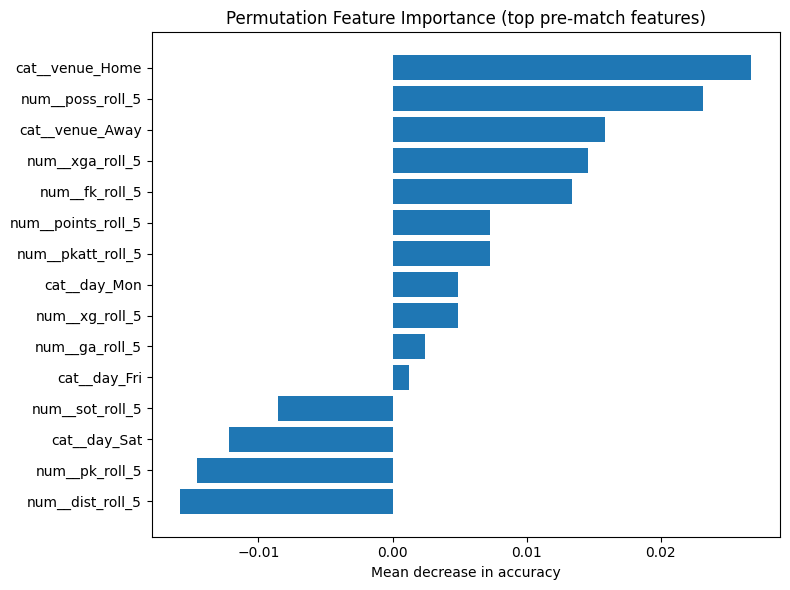

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
)
from sklearn.inspection import permutation_importance

# ======================================================
# 1. Load raw match data
# ======================================================
df = pd.read_csv("matches.csv")

# Basic cleaning
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Make date a datetime and sort
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["team", "date", "time"]).reset_index(drop=True)

# ======================================================
# 2. Build pre-match rolling features (last 5 games)
# ======================================================

# Numeric stats we will roll over past 5 games
stat_cols = [
    "gf", "ga",       # goals for / against
    "xg", "xga",      # expected goals for / against
    "sh", "sot",      # shots, shots on target
    "dist",           # average shot distance
    "fk", "pk", "pkatt",
    "poss",           # possession %
]

# Map result W/D/L to points for "form"
points_map = {"W": 3, "D": 1, "L": 0}
df["points"] = df["result"].map(points_map)

window = 5

def add_rolling_features(g):
    g = g.sort_values(["date", "time"])
    for col in stat_cols + ["points"]:
        # rolling(window) over PAST games, then shift(1) so current row
        # only sees matches that happened before this match
        g[f"{col}_roll_{window}"] = (
            g[col].rolling(window=window, min_periods=1).mean().shift(1)
        )
    return g

df = df.groupby("team", group_keys=False).apply(add_rolling_features)

# Drop rows that have no history at all (first game for each team)
roll_cols = [c for c in df.columns if c.endswith(f"_roll_{window}")]
df_model = df.dropna(subset=roll_cols).copy()

# ======================================================
# 3. Create the TARGET: Home / Draw / Away
#    From the HOME TEAM's perspective
# ======================================================
def map_outcome(row):
    # We only use result + venue here, NOT as features
    if row["result"] == "D":
        return "D"
    if row["result"] == "W":
        return "H" if row["venue"] == "Home" else "A"
    if row["result"] == "L":
        return "A" if row["venue"] == "Home" else "H"
    return np.nan

df_model["outcome"] = df_model.apply(map_outcome, axis=1)
df_model = df_model.dropna(subset=["outcome"])

# ======================================================
# 4. Choose features (ONLY pre-match information)
# ======================================================

numeric_features = roll_cols  # all the *_roll_5 features

# Categorical features known before kickoff
categorical_features = ["venue", "day", "team", "opponent", "season"]

X = df_model[numeric_features + categorical_features]
y = df_model["outcome"]

# ======================================================
# 5. Preprocessing + SVM model + 80/20 split
# ======================================================
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

svm_clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", SVC(kernel="rbf", C=2.0, gamma="scale",
                      probability=True, random_state=42)),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Test accuracy (pre-match SVM): {acc:.3f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=3))

# ======================================================
# 6. Confusion matrix (H / D / A)
# ======================================================
labels = ["H", "D", "A"]

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Home win", "Draw", "Away win"]
)

plt.figure(figsize=(6, 5))
disp.plot(values_format="d", cmap="viridis")
plt.title("SVM Confusion Matrix (80/20 pre-match split)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

# ======================================================
# 7. 2D SVM decision boundary for presentation
#    Use ONLY home matches, with:
#    x-axis: avg goals scored last 5 games
#    y-axis: avg goals conceded last 5 games
# ======================================================

home_rows = df_model[df_model["venue"] == "Home"].copy()
home_rows = home_rows.dropna(subset=["gf_roll_5", "ga_roll_5"])

X2 = home_rows[["gf_roll_5", "ga_roll_5"]].values
y2 = home_rows["outcome"].values  # H/D/A from home perspective

from sklearn.preprocessing import StandardScaler

scaler_2d = StandardScaler()
X2_scaled = scaler_2d.fit_transform(X2)

svm_2d = SVC(kernel="rbf", C=2.0, gamma="scale", random_state=42)
svm_2d.fit(X2_scaled, y2)

# Build 2D grid
x_min, x_max = X2_scaled[:, 0].min() - 1, X2_scaled[:, 0].max() + 1
y_min, y_max = X2_scaled[:, 1].min() - 1, X2_scaled[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Map classes to ints for contourf
class_order = ["H", "D", "A"]
class_to_int = {cls: i for i, cls in enumerate(class_order)}
Z_int = np.vectorize(class_to_int.get)(Z)

plt.figure(figsize=(7, 6))
# Decision regions
contour = plt.contourf(xx, yy, Z_int, alpha=0.3)

# Plot the actual matches
markers = {"H": "o", "D": "s", "A": "^"}
colors = {"H": "tab:blue", "D": "tab:orange", "A": "tab:green"}

for cls in class_order:
    idx = np.where(y2 == cls)
    plt.scatter(
        X2_scaled[idx, 0],
        X2_scaled[idx, 1],
        label=cls,
        marker=markers[cls],
        edgecolor="k",
        alpha=0.7,
    )

plt.xlabel("Home team avg goals scored (last 5, scaled)")
plt.ylabel("Home team avg goals conceded (last 5, scaled)")
plt.title("SVM decision boundary\nHome team attack vs defence (pre-match)")
plt.legend(title="Outcome (H/D/A)")
plt.tight_layout()
plt.show()

# ======================================================
# 8. Permutation Feature Importance (top 15)
# ======================================================

print("\nComputing permutation feature importance (this may take a bit)...")
result = permutation_importance(
    svm_clf,
    X_test,
    y_test,
    n_repeats=3,
    random_state=42,
    n_jobs=-1,
)

preprocess_fitted = svm_clf.named_steps["preprocess"]
feature_names = preprocess_fitted.get_feature_names_out()

importances_mean = result.importances_mean
indices = np.argsort(importances_mean)[::-1]

top_n = 15
top_indices = indices[:top_n]

print("\nTop feature importances (pre-match features only):")
for i in top_indices:
    print(f"{feature_names[i]}: {importances_mean[i]:.4f}")

plt.figure(figsize=(8, 6))
plt.barh(
    range(len(top_indices)),
    importances_mean[top_indices][::-1],
)
plt.yticks(
    range(len(top_indices)),
    [feature_names[i] for i in top_indices][::-1],
)
plt.xlabel("Mean decrease in accuracy")
plt.title("Permutation Feature Importance (top pre-match features)")
plt.tight_layout()
plt.show()